# Closing the Amoritization Gap in Deep Bayesian Generative Models

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200710000625/variational.jpg" width="100%"></img>

_Created by: [Jordan Deklerk](https://github.com/jordandeklerk), [Visit My Website](https://jordandeklerk.github.io)_

## Contents
- [Background](#background)
    - [Inference in Variational Autoencoders](#inference-in-variational-autoencoders)
    - [Amoritization Gap](#amortization-gap)
    - [Project Overview](#project-overview)
    - [The Reparameterization Trick](#the-reparameterization-trick)
- [Visualize Sample Data](#visualize-sample-data)
- [Config](#config)
- [Model Setup](#model-setup)
    - [Encoder](#encoder)
    - [Decoder](#decoder)
- [Main Model Overview](#main-model-overview)
- [Train the Model](#train-the-model)
    - [Experiment Wrapper](#experiment-wrapper)
- [Run the Experiments](#run-the-experiments)
- [Results](#results)
    - [Computation Time](#computation-time)
- [Conclusion](#conclusion)

---

## Background

In the Bayesian paradigm, statistical inference regarding unknown variables is predicated on computations involving posterior probability densities. Due to the often intractable nature of these densities, which typically lack an analytic form, estimation becomes crucial. Classical methods for estimating the posterior distribution in Bayesian inference such as MCMC are known to be computationally expensive at test time as they rely on repeated evaluations of the likelihood function and, therefore, require a new set of likelihood evaluations for each observation. In contrast, Variational Inference (VI) offers a compelling solution by recasting the difficult task of estimating complex posterior densities into a more manageable optimization problem. The essence of VI lies in selecting a parameterized distribution family, $\mathcal{Q}$, and identifying the member that minimizes the Kullback-Leibler (KL) divergence from the posterior,

$$
q^* = \arg \min _{q \in \mathcal{Q}} \mathrm{KL}(q(\theta, \mathbf{z}) \| p(\theta, \mathbf{z} \mid \mathbf{x})).
$$

This process enables the approximation of the posterior with $q^*$, thereby delineating the VI objective to entail the selection of an appropriate variational family $\mathcal{Q}$ for optimization. Common practice in VI applications involves the adoption of the factorized, or mean-field, family. This family is characterized by the independence of the variables

$$
\mathcal{Q}_{\mathrm{F}}=\left\{q: q(\theta, \mathbf{z})=q_0(\theta) \prod_{n=1}^N q_n\left(z_n\right)\right\},
$$

wherein each latent variable is represented by a distinct factor $q_n$. 

Contrary to the VI framework, the amortized family $\mathcal{Q}_{\mathrm{A}}$ leverages a stochastic inference function $f_{\phi}(x_n)$ to dictate the variational distribution of each latent variable $z_n$, typically instantiated through a neural network, facilitating the parameter mapping for each latent variable's approximating factor $q_n(z_n)$:

$$
\mathcal{Q}_{\mathrm{A}}=\left\{q: q(\theta, \mathbf{z})=q_0(\theta) \prod_{n=1}^N q\left(z_n ; f_\phi\left(x_n\right)\right)\right\}.
$$

This paradigm, known as *amortized variational inference* (A-VI), optimizes the approximation of the posterior and the inference function simultaneously. Therefore, inference on a single observation can be performed efficiently through a single forward pass through the neural network, framing Bayesian inference as a prediction problem: for *any* observation, the neural network is trained to predict the posterior distribution, or a quantity that allows the network to infer the posterior without any further simulations.

### Inference in Variational Autoencoders

Consider \(x\) as the observed variable, \(z\) as the hidden variable, and \(p(x, z)\) representing their joint distribution. For a dataset \(X = \{x_1, x_2, \ldots, x_N\}\), our goal is to maximize the marginal \(\log\)-likelihood with respect to the model parameters \(\theta\), expressed as

$$
\log p_\theta(X) = \sum_{i=1}^N \log p_\theta(x_i) = \sum_{i=1}^N \log \int p_\theta(x_i, z_i) \, dz_i.
$$

However, calculating the marginal log-likelihood directly is not feasible due to the integral over the hidden variable \(z\). To address this, Variational Autoencoders (VAEs) employ an inference network \(q_\phi(z | x)\) as an approximation to the actual posterior \(p(z | x)\) and optimize the Evidence Lower Bound (ELBO) relative to both the model parameters \(\theta\) and the parameters \(\phi\) of the inference network:

$$
\log p(x) = \mathbb{E}_{q(z | x)}\left[\log \left(\frac{p(x, z)}{q(z | x)}\right)\right] + \text{KL}(q(z | x) \| p(z | x)) \geq \mathbb{E}_{q(z | x)}\left[\log \left(\frac{p(x, z)}{q(z | x)}\right)\right] = \mathcal{L}_{\text{VAE}}[q].
$$

The ELBO is equivalent to the true log likelihood when \(q(z | x) = p(z | x)\). Typically, \(q(z | x)\) is chosen to be a factorized Gaussian for its simplicity and computational efficiency. VAEs leverage the inference network (also known as the encoder or recognition network) to generalize inference across the entire dataset efficiently. The model is trained by stochastically optimizing the ELBO through the reparametrization trick, introduced by Kingma.

### Amortization Gap

As illustrated by Cremer, the inference gap, denoted as \(\mathcal{G}\), represents the discrepancy between the marginal \(\log\)-likelihood, \(\log p(x)\), and a specific lower bound, \(\mathcal{L}[q]\). Identifying the distribution within the set that optimizes this bound, denoted as \(q^*(z | x) = \arg \max _{q \in \mathcal{Q}} \mathcal{L}[q]\), allows for the decomposition of \(\mathcal{G}\) into two distinct components: the *approximation gap* and the *amortization gap*, expressed as

$$
\mathcal{G} = \log p(x) - \mathcal{L}[q] = \underbrace{\log p(x) - \mathcal{L}\left[q^*\right]}_{\text{Approximation}} + \underbrace{\mathcal{L}\left[q^*\right] - \mathcal{L}[q]}_{\text{Amortization}}.
$$

In the context of Variational Autoencoders (VAEs), these gaps can be articulated through KL divergences by reorganizing the equation as follows:

$$
\mathcal{G}_{\mathrm{VAE}}  = \underbrace{\operatorname{KL}\left(q^*(z | x) \| p(z | x)\right)}_{\text{Approximation}} + \underbrace{\operatorname{KL}(q(z | x) \| p(z | x)) - \operatorname{KL}\left(q^*(z | x) \| p(z | x)\right)}_{\text{Amortization}}.
$$

### The Reparameterization Trick

#### Non-differentiable Expectations

Consider the scenario where we need to compute the gradient concerning $\theta$ for the expectation,
$$
\mathbb{E}_{p(z)}[f_\theta(z)]
$$
Here, $p$ represents a probability density. Assuming that $f_\theta(z)$ is differentiable, the computation of the gradient becomes straightforward:
$$
\begin{aligned}
\nabla_\theta \mathbb{E}_{p(z)}[f_\theta(z)] &= \nabla_\theta\left[\int_z p(z) f_\theta(z) \, dz\right] \\
&= \int_z p(z)\left[\nabla_\theta f_\theta(z)\right] \, dz \\
&= \mathbb{E}_{p(z)}[\nabla_\theta f_\theta(z)]
\end{aligned}
$$

In essence, the gradient of the expectation equals the expectation of the gradient. However, complications arise if the density $p$ also depends on $\theta$:
$$
\begin{aligned}
\nabla_\theta \mathbb{E}_{p_\theta(z)}[f_\theta(z)] &= \nabla_\theta\left[\int_z p_\theta(z) f_\theta(z) \, dz\right] \\
&= \int_z \nabla_\theta\left[p_\theta(z) f_\theta(z)\right] \, dz \\
&= \int_z f_\theta(z) \nabla_\theta p_\theta(z) \, dz + \int_z p_\theta(z) \nabla_\theta f_\theta(z) \, dz \\
&= \underbrace{\int_z f_\theta(z) \nabla_\theta p_\theta(z) \, dz}_{\text{How about this part?}} + \mathbb{E}_{p_\theta(z)}[\nabla_\theta f_\theta(z)]
\end{aligned}
$$

The initial part of the final equation doesn't necessarily equate to an expectation. While Monte Carlo techniques allow sampling from $p_\theta(z)$, they do not ensure the gradient of this sampling process is obtainable. This poses no issue if there exists an analytic solution for $\nabla_\theta p_\theta(z)$, but such a solution is not always available.

With a clearer understanding of the challenge, let's explore the application of the reparameterization trick to our example. Following Kingma's notation, vectors are denoted in bold, $\mathbf{v}^{(i)}$ represents the $i$-th sample of vector $\mathbf{v}$, and $l \in L$ signifies the $l$-th Monte Carlo sample. The reparameterization trick is utilized to shift from a gradient of an expectation to an expectation of a gradient, facilitating the use of Monte Carlo estimations for gradients involving expectations. This transition is pivotal, especially when the function $g_{\boldsymbol{\theta}}$ is differentiable, a point that Kingma underscores. The mathematical flow is as follows:

- Noise variables $\boldsymbol{\epsilon}$ are drawn from a predefined distribution $p(\boldsymbol{\epsilon})$.
- These variables, along with input $\mathbf{x}$, are transformed by $g_{\boldsymbol{\theta}}$ to obtain $\mathbf{z}$.
- The expectation with respect to $p_\theta(\mathbf{z})$ is equated to an expectation with respect to $p(\boldsymbol{\epsilon})$, leveraging the function $g_\theta$.
- Subsequently, the gradient of the expectation with respect to $\boldsymbol{\theta}$ is expressed and approximated via Monte Carlo sampling.

Formally, this can be represented as:

$$
\begin{aligned}
\boldsymbol{\epsilon} & \sim p(\boldsymbol{\epsilon}) \\
\mathbf{z} & =g_{\boldsymbol{\theta}}(\boldsymbol{\epsilon}, \mathbf{x}) \\
\mathbb{E}_{p_\theta(\mathbf{z})}\left[f\left(\mathbf{z}^{(i)}\right)\right] & =\mathbb{E}_{p(\boldsymbol{\epsilon})}\left[f\left(g_\theta\left(\boldsymbol{\epsilon}, \mathbf{x}^{(i)}\right)\right)\right] \\
\nabla_\theta \mathbb{E}_{p_{\boldsymbol{\theta}}(\mathbf{z})}\left[f\left(\mathbf{z}^{(i)}\right)\right] & =\nabla_\theta \mathbb{E}_{p(\boldsymbol{\epsilon})}\left[f\left(g_{\boldsymbol{\theta}}\left(\boldsymbol{\epsilon}, \mathbf{x}^{(i)}\right)\right)\right] \\
& =\mathbb{E}_{p(\boldsymbol{\epsilon})}\left[\nabla_{\boldsymbol{\theta}} f\left(g_{\boldsymbol{\theta}}\left(\boldsymbol{\epsilon}, \mathbf{x}^{(i)}\right)\right)\right] \\
& \approx \frac{1}{L} \sum_{l=1}^L \nabla_{\boldsymbol{\theta}} f\left(g_{\boldsymbol{\theta}}\left(\epsilon^{(l)}, \mathbf{x}^{(i)}\right)\right)
\end{aligned}
$$

Understanding this process is crucial for comprehending VAEs, highlighting the importance of differentiability and the practical application of the reparameterization trick for gradient estimation.

**Sanity Check**

It's important to emphasize that this explanation aligns with Kingma's reasoning. As Kingma states: "This reparameterization is useful for our case since it can be used to rewrite an expectation with respect to $q_{\phi}(\mathbf{z} \mid \mathbf{x})$ so that the Monte Carlo estimate of the expectation is differentiable with respect to $\phi$."

The challenge isn't technically about the inability to backpropagate through a "random node". The issue is more about backpropagation not providing an estimate of the derivative. Without employing the reparameterization trick, there's no assurance that sampling a large number of $\mathbf{z}$ values will lead to a correct estimate of $\nabla_{\theta}$.

Moreover, this issue directly relates to the problem we encounter with estimating the ELBO:

$$
\begin{aligned}
\text{ELBO}(\boldsymbol{\theta}, \boldsymbol{\phi}) & = \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z}) - \log q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})\right] \\
& \downarrow \\
\nabla_{\theta, \phi} \text{ELBO}(\boldsymbol{\theta}, \boldsymbol{\phi}) & = \nabla_{\theta, \phi}\left[\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z})}\left[\log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z}) - \log q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})\right]\right]
\end{aligned}
$$

Notice that the equation above doesn't quite resemble what is computed in a standard VAE. In his paper, Kingma introduces two estimators, denoted as $\mathcal{L}^A$ and $\mathcal{L}^B$. The equation for $\mathcal{L}^A$ is shown above, while $\mathcal{L}^B$ applies when there's an analytic solution for the KL-divergence term in the ELBO, such as when assuming Gaussian distributions for both the prior $p_{\boldsymbol{\theta}}(\mathbf{z})$ and the posterior approximation $q_{\phi}(\mathbf{z} \mid \mathbf{x})$:

$$
\nabla_{\theta, \phi} \mathcal{L}^B = -\nabla_{\theta, \phi} \left[\text{KL}\left[q_{\phi}(\mathbf{z} \mid \mathbf{x}^{(i)}) \| p_{\theta}(\mathbf{z})\right]\right] + \nabla_{\theta, \phi} \left[\frac{1}{L} \sum_{l=1}^L \log p_{\boldsymbol{\theta}}(\mathbf{x}^{(i)} \mid \mathbf{z}^{(l)})\right]
$$

Now, with the capability to compute the full loss through a series of differentiable operations, gradient-based optimization techniques can be applied to maximize the ELBO.

#### Implementation

Closing the loop with implementation details, the standard VAE follows the equation derived by Kingma for the KL term in Appendix 2. This equation presents the model with the likelihood as a "decoder" and the approximate posterior as an "encoder":
$$
\mathcal{L}^B = -\text{KL}\left[q_\phi(\mathbf{z} \mid \mathbf{x}^{(i)}) \ \| \ p_\theta(\mathbf{z})\right] + \frac{1}{L} \sum_{l=1}^L \log p_{\boldsymbol{\theta}}(\mathbf{x}^{(i)} \mid \mathbf{z}^{(l)})
$$

This can be understood as follows: the KL-divergence term encourages the encoder's output to resemble the fixed prior distribution $p_{\boldsymbol{\theta}}(\mathbf{z})$. Ideally, if the encoder perfectly captures both the real posterior and the prior, Bayes' rule would imply $p(\mathbf{x})=p(\mathbf{x} \mid \mathbf{z})$, aligning with the objectives of a generative model. Through the reparameterization trick, we can sample $\mathbf{z}$ and conditionally generate realistic samples of $\mathbf{x}$.

A single computational graph pass for Gaussian priors and posteriors might look like this:

$$
\begin{aligned}
\boldsymbol{\mu}_x, \boldsymbol{\sigma}_x & = \text{Encoder}(\mathbf{x}) & & \quad \text{Push $\mathbf{x}$ through encoder} \\
\boldsymbol{\epsilon} & \sim \mathcal{N}(0,1) & & \quad \text{Sample noise} \\
\mathbf{z} & = \boldsymbol{\epsilon} \boldsymbol{\sigma}_x + \boldsymbol{\mu}_x & & \quad \text{Reparameterize} \\
\mathbf{x}_r & = \text{Decoder}(\mathbf{z}) & & \quad \text{Push $\mathbf{z}$ through decoder} \\
\text{Recon. Loss} & = \text{MSE}(\mathbf{x}, \mathbf{x}_r) & & \quad \text{Compute reconstruction loss} \\
\text{Var. Loss} & = -\text{KL}\left[\mathcal{N}(\boldsymbol{\mu}_x, \boldsymbol{\sigma}_x^2) \ \| \ \mathcal{N}(0, I)\right] & & \quad \text{Compute variational loss} \\
\text{Total Loss} & = \text{Recon. Loss} + \text{Var. Loss} & & \quad \text{Combine losses}
\end{aligned}
$$

By computing each variable in this graph through differentiable operations, backpropagation can be applied to compute gradients.

![Reparameterization Technique](./reparm4.png)

### Project Overview

This project will attempt to comprehensively expound and apply amortized variational inference (A-VI) within the realm of Bayesian probabilistic modeling, presenting a dual focus on theoretical insights and practical applications. We seek to understand the comparative advantages of A-VI over traditional variational inference approaches such as factorized and constant variational inference, particularly emphasizing the role of deep neural networks in enhancing inference efficiency. 

The theoretical exploration aims to furnish a clear understanding of A-VI's foundational principles. On the practical front, the project is designed to showcase A-VI's versatility by illustrating how we can close the amortization gap in Variational Autoencoders (VAEs) while doing comprehensive Bayesian inference on benchmark imaging datasets. Ultimately, this project aims to bridge theoretical acumen with empirical application, highlighting A-VI's efficacy in navigating the intricacies of advanced Bayesian probabilistic modeling.


In [ ]:
%%capture
!pip install wandb ipywidgets

Let's first import all of the necessary libraries we will be using in this tutorial. We will be working mainly with `torch` and `torchvision`. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import time
import os
import wandb
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.optim import AdamW, Adam

from typing import Tuple

from tqdm import tqdm
import random

from ipywidgets import Widget
Widget.close_all()

Let's define our global arguments using the argument parser, enabling us to conveniently adjust and experiment with various hyperparameters.

In [ ]:
def get_args_parser():
    parser = argparse.ArgumentParser('Bayesian VAE', add_help=False)
    parser.add_argument('--dataset', default='MNIST', type=str, choices=['MNIST', 'CIFAR10', 'FashionMNIST', 'SVHN'],
                        help='dataset to use')
    parser.add_argument('--batch_size', default=10000, type=int,
                        help='batch size')
    parser.add_argument('--epochs', default=5000, type=int,
                        help='number of total epochs to run')
    parser.add_argument('--lr', default=1e-3, type=float,
                        help='initial learning rate')
    parser.add_argument('--weight_decay', default=1e-1, type=float,
                        help='weight decay')
    parser.add_argument('--z_dim', default=64, type=int,
                        help='z dimension')
    parser.add_argument('--like_dim', default=256, type=int,
                        help='likelihood dimension')
    parser.add_argument('--nn_widths', default=[1, 64, 128, 256], type=list,
                        help='neural network widths')
    parser.add_argument('--n_obs', default=10000, type=int,
                        help='number of observations')
    parser.add_argument('--mc_samples', default=100, type=int,
                        help='number of monte carlo samples')
    parser.add_argument('--seed', default=315, type=int,
                        help='seed')
    return parser

args, unknown = get_args_parser().parse_known_args()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Visualize Sample Data

Let's explore some sample images from the datasets we'll be using in this project. It's important to note that our primary focus will be on the `MNIST` dataset, primarily due to its lower computational requirements for this tutorial. However, the insights and results obtained from the `MNIST` dataset are applicable to the other datasets as well. Feel free to experiment with different image datasets to see how they perform!

In [ ]:
class CustomDatasetLoader:
    def __init__(self, dataset_name, dataset_path, batch_size, use_basic_transform=False, num_workers=8, pin_memory=True, img_size=32):
        self.dataset_name = dataset_name
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.use_basic_transform = use_basic_transform
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.img_size = img_size

        self.setup_transforms()
        self.load_dataset()

    def setup_transforms(self):
        if self.use_basic_transform:
            self.train_transform = self.val_transform = transforms.Compose([
                transforms.Resize((self.img_size, self.img_size)),
                transforms.ToTensor()
            ])
        elif self.dataset_name in ["CIFAR10", "SVHN"]:
            self.train_transform, self.val_transform = self.get_cifar10_svhn_transforms()
        else:
            self.train_transform = self.val_transform = transforms.Compose([transforms.ToTensor()])

    def get_cifar10_svhn_transforms(self):
        train_transform = transforms.Compose([
            transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float),
            transforms.RandomErasing(p=0.1)
        ])
        val_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor()
        ])
        return train_transform, val_transform

    def load_dataset(self):
        if self.use_basic_transform:
            transform = transforms.Compose([
                transforms.ToTensor()
            ])
        else:
            if self.dataset_name in ["CIFAR10", "SVHN"]:
                transform = self.get_cifar10_svhn_transforms()
            else:
                transform = transforms.Compose([transforms.ToTensor()])

        if self.dataset_name == "CIFAR10":
            train_dataset = CIFAR10(self.dataset_path, train=True, download=True, transform=transform)
            test_dataset = CIFAR10(self.dataset_path, train=False, download=True, transform=transform)
        elif self.dataset_name == "SVHN":
            train_dataset = SVHN(self.dataset_path, split='train', download=True, transform=transform)
            test_dataset = SVHN(self.dataset_path, split='test', download=True, transform=transform)
        else:
            dataset_class = globals()[self.dataset_name]
            train_dataset = dataset_class(self.dataset_path, train=True, download=True, transform=transform)
            test_dataset = dataset_class(self.dataset_path, train=False, download=True, transform=transform)

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=self.pin_memory)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=self.pin_memory)

In [ ]:
def imshow(img, title=None):
    """Utility function to show an image using matplotlib."""
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def visualize_dataset_images(dataloader, dataset_name, classes=None):
    """Visualize images for a given dataset."""
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images[:4]), title=f"Sample images from {dataset_name}")

    if classes is not None:
        labels = [classes[label] for label in labels[:4]]
        print("Labels:", labels)

Let's visualize a few sample images from each of the datasets we're working with.

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


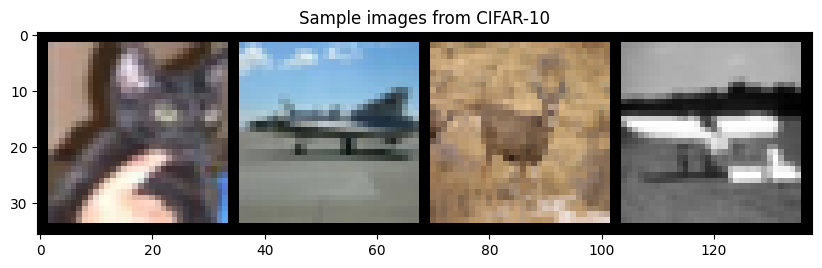

Labels: ['cat', 'airplane', 'deer', 'airplane']


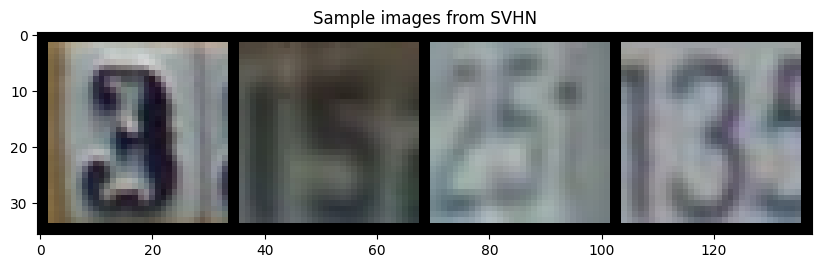

Labels: ['3', '5', '5', '3']


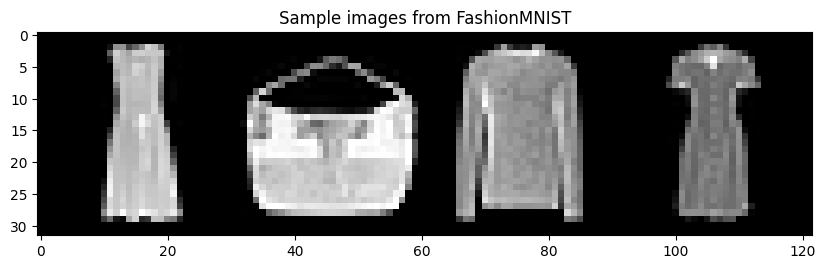

Labels: ['Dress', 'Bag', 'Pullover', 'Dress']


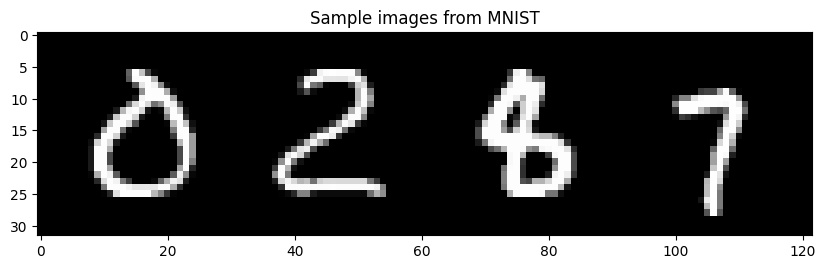

Labels: ['0', '2', '8', '7']


In [ ]:
cifar_loader = CustomDatasetLoader("CIFAR10", 'data', 128, use_basic_transform=True, img_size=32)
svhn_loader = CustomDatasetLoader("SVHN", 'data', 128, use_basic_transform=True, img_size=32)
fashion_mnist_loader = CustomDatasetLoader("FashionMNIST", 'data', 128, use_basic_transform=True, img_size=28)
mnist_loader = CustomDatasetLoader("MNIST", 'data', 128, use_basic_transform=True, img_size=28)


cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
svhn_classes = [str(i) for i in range(10)]
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
mnist_classes = [str(i) for i in range(10)]


visualize_dataset_images(cifar_loader.train_loader, "CIFAR-10", classes=cifar_classes)
visualize_dataset_images(svhn_loader.train_loader, "SVHN", classes=svhn_classes)
visualize_dataset_images(fashion_mnist_loader.train_loader, "FashionMNIST", classes=fashion_mnist_classes)
visualize_dataset_images(mnist_loader.train_loader, "MNIST", classes=mnist_classes)

## Configuration

We are now ready to establish the configurations for the four datasets we plan to explore. In the following setup, we will define the input dimension (`x_dim`), the hidden dimension (`hidden_dim`), and the latent dimension (`latent_dim`). 

- The `x_dim` specifies the size of the input data, which in our context refers to the dimensions of an image. It's important to note that `MNIST`, `FashionMNIST`, and `SVHN` datasets consist of grayscale images, whereas the `CIFAR-10` dataset comprises RGB images.
- The `hidden_dim` indicates the size of the neural network's hidden layers, essentially representing the network's width at each layer.
- Lastly, the `latent_dim` denotes the size of the latent space to which the Encoder compresses the input data, providing a compact representation of the original input.

These configurations are crucial for tailoring our model to effectively handle the specific characteristics of each dataset.

In [ ]:
dataset_path = '~/datasets'

dataset_configs = {
    "MNIST": {"x_dim": 28 * 28, "hidden_dim": 400, "latent_dim": 200, "dataset": MNIST},
    "FashionMNIST": {"x_dim": 28 * 28, "hidden_dim": 400, "latent_dim": 200, "dataset": FashionMNIST},
    "CIFAR10": {"x_dim": 32 * 32 * 3, "hidden_dim": 128, "latent_dim": 100, "dataset": CIFAR10},
    "SVHN": {"x_dim": 32 * 32, "hidden_dim": 128, "latent_dim": 100, "dataset": SVHN},
}

transform = transforms.Compose([transforms.ToTensor()])
kwargs = {'num_workers': 4, 'pin_memory': True}

def get_dataset(data_set_name, dataset_path, transform, **kwargs):
    if data_set_name not in dataset_configs:
        raise ValueError(f"Unsupported dataset: {data_set_name}")

    config = dataset_configs[data_set_name]
    dataset_class = config["dataset"]

    if data_set_name == "SVHN":
        train_dataset = dataset_class(root=dataset_path, split='train', transform=transform, download=True)
        test_dataset = dataset_class(root=dataset_path, split='test', transform=transform, download=True)
    else:
        train_dataset = dataset_class(root=dataset_path, train=True, transform=transform, download=True)
        test_dataset = dataset_class(root=dataset_path, train=False, transform=transform, download=True)

    return train_dataset, test_dataset

train_dataset, test_dataset = get_dataset(args.dataset, dataset_path, transform, **kwargs)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 242044322.57it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26185839.56it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80374350.89it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 8120429.99it/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



## Model Setup

### Encoder

The encoder is a type of neural network that takes an input, such as a 28x28 pixel image of a handwritten digit (which makes it a 784-dimensional vector), and compresses it into a smaller, or latent, representation denoted as $z$. This process involves learning to reduce the data from its original high dimensionality to a more compact form, often called a "bottleneck," because it forces the network to find an efficient way to represent the data in fewer dimensions. The function of the encoder is captured by $q_\theta(z | x)$, where it actually outputs parameters defining a Gaussian distribution from which we can sample the latent representation $z$.


In [ ]:
class Encoder(nn.Module):
    """
    Encoder module for a Variational Autoencoder (VAE), transforming input data into a latent space representation.

    The encoder consists of sequential linear layers with LeakyReLU activations, followed by separate linear layers
    for producing the mean and log variance vectors.

    Parameters:
    - input_dim (int): Dimensionality of the input data.
    - hidden_dim (int): Size of the hidden layer(s). This implementation uses two hidden layers of the same size.
    - latent_dim (int): Dimensionality of the latent space representation (output).
    - use_bias (bool, optional): Whether to include bias terms in the linear layers (default: True).
    """
    def __init__(self, input_dim, hidden_dims, latent_dim, use_bias=True):
        super(Encoder, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dims[0], bias=use_bias), nn.LeakyReLU(0.2)]
        layers.extend([
            nn.Linear(hidden_dims[i], hidden_dims[i + 1], bias=use_bias) for i in range(len(hidden_dims) - 1)
        ])
        layers.append(nn.LeakyReLU(0.2))

        self.features = nn.Sequential(*layers)
        self.FC_mean = nn.Linear(hidden_dims[-1], latent_dim, bias=use_bias)
        self.FC_sd_log = nn.Linear(hidden_dims[-1], latent_dim, bias=use_bias)

    def forward(self, x):
        h = self.features(x)
        mean = self.FC_mean(h)
        sd_log = self.FC_sd_log(h)
        return mean, sd_log

    def init_weights(self, nu_mean_z=None, nu_sd_z_log=None, init_type='zero', device='cpu'):
        """
        Initializes the encoder's weights and biases, supporting custom initial values for
        mean and log standard deviation biases, and allowing for more initialization types.

        Parameters:
        - nu_mean_z: Initial value for the variational mean of z, applicable to FC_mean bias.
        - nu_sd_z_log: Initial values for the variational log standard deviation of z, applicable to FC_sd_log bias.
        - init_type (str, optional): The type of weight initialization ('zero', 'normal', etc.).
        - device: The device to allocate tensors to ('cpu', 'cuda', etc.).
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_type == 'zero':
                    nn.init.zeros_(m.weight)
                elif init_type == 'normal':
                    nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        if nu_mean_z is not None:
            self.FC_mean.bias.data = nu_mean_z.to(device)
        if nu_sd_z_log is not None:
            self.FC_sd_log.bias.data = nu_sd_z_log.to(device)

### Decoder

On the flip side, the decoder is a complementary neural network that takes the encoded latent representation $z$ and works to reconstruct the original data from it. The decoder is represented by $p_\phi(x | z)$ and aims to output parameters that define the probability distribution of the original data points. Continuing with the handwritten digit example, where each pixel is either black or white, the output distribution for each pixel can be modeled as a Bernoulli distribution. Thus, from a given latent representation $z$, the decoder produces 784 probabilities, corresponding to the 784 pixels, to recreate the image.

The reconstruction process isn't perfect—there's information loss because the decoder operates on a condensed version of the original data. We assess this loss through the reconstruction log-likelihood, $\log p_\phi(x | z)$. This metric evaluates how well the decoder has learned to regenerate an input image $x$ from its encoded version $z$, reflecting the efficiency of the compression and reconstruction process.

In [ ]:
def Decoder(theta, z, latent_dim, hidden_dim, x_dim):
    """
    Reconstructs the network output from latent inputs using specified network architecture.

    Args:
        theta (Tensor): A flat tensor of the network's parameters (weights and biases),
                        ordered with all weights first followed by all biases.
        z (Tensor): The latent inputs to the network, typically representing encoded data.
        latent_dim (int): The size of the latent input dimension.
        hidden_dim (int): The size of the hidden layers in the network.
        x_dim (int): The size of the output dimension, or the dimensionality of the data being reconstructed.

    Returns:
        Tensor: The reconstructed output from the network.
    """
    expected_theta_size = latent_dim * hidden_dim + hidden_dim**2 + hidden_dim * x_dim + 2 * hidden_dim + x_dim
    if theta.numel() != expected_theta_size:
        raise ValueError("Theta size does not match the expected size based on dimensions.")

    indices = [latent_dim * hidden_dim, hidden_dim**2, hidden_dim * x_dim, hidden_dim, hidden_dim, x_dim]
    splits = torch.split(theta, indices)
    W1, W2, W3, b1, b2, b3 = [splits[i].reshape(shape) for i, shape in enumerate([
        (hidden_dim, latent_dim), (hidden_dim, hidden_dim), (x_dim, hidden_dim),
        (hidden_dim,), (hidden_dim,), (x_dim,)
    ])]

    LeakyRelu = nn.LeakyReLU(0.2)
    h = LeakyRelu(z @ W1.T + b1)
    h = LeakyRelu(h @ W2.T + b2)
    out = h @ W3.T + b3
    return out

We will need to define some utility functions to use when calculating the ELBO.

In [ ]:
# Utility functions 
def gaussian_lpdf(x, mu, sigma_2):
    """
    Computes the log probability density function for a Gaussian distribution.

    Parameters:
    - x: Tensor of observed values.
    - mu: Tensor of means for the Gaussian distribution.
    - sigma_2: Tensor of variances for the Gaussian distribution.
    """
    return -0.5 * torch.sum((x - mu)**2 / sigma_2 + torch.log(sigma_2))

def log_joint_gaussian(x, mu, sigma, z, theta):
    """
    Computes the log joint probability for a dataset with Gaussian likelihood,
    standard Gaussian priors on z and theta.
    """
    like_weight = z.size(0) / x.size(0)
    return -0.5 * torch.sum(z**2) - like_weight * torch.sum((x - mu)**2) - 0.5 * torch.sum(theta**2)

def log_q(theta, z, nu_mean_theta, nu_sd_theta_2, nu_mean_z, nu_sd_z_2):
    """
    Evaluates the log density of the Gaussian variational approximation for theta and z,
    given means and variances of the variational distributions.
    """
    log_q_theta = -0.5 * torch.sum(torch.log(nu_sd_theta_2) + (theta - nu_mean_theta)**2 / nu_sd_theta_2)
    log_q_z = -0.5 * torch.sum(torch.log(nu_sd_z_2) + (z - nu_mean_z)**2 / nu_sd_z_2)
    return log_q_theta + log_q_z

## Main Model Overview

With both the encoder and decoder components in place, alongside essential utility functions, we can now introduce our central model class. 

This class acts as the backbone of our setup, incorporating options for Amortized Variational Inference (A-VI), Free-form Variational Inference (F-VI), and Constant Variational Inference. It encompasses methods for initializing variational parameters, applying the reparameterization technique to $z$ and $\theta$, and calculating both the Evidence Lower Bound (ELBO) and the Mean Squared Error (MSE) for reconstruction.

In [ ]:
class Model(nn.Module):
    """
    Implements a PyTorch module for variational inference in a variational autoencoder (VAE) setup.

    Parameters:
        x_dim (int): Dimensionality of the input data.
        z_dim (int): Dimensionality of the latent space.
        like_dim (int): Dimensionality of the likelihood parameter space.
        n_obs (int): Number of observations in the dataset.
        use_avi (bool): Flag to use amortized variational inference (default: True).
        hidden_dim (int): Dimensionality of the hidden layer(s) in the encoder. If set to 0, defaults to double the z_dim.
        const_z (bool): Flag to use a constant latent variable z (default: False).
        mc_samples (int): Number of Monte Carlo samples to use for estimating the ELBO.
        nu_mean_z_init (torch.Tensor or None): Initial values for the mean of the latent variable z.
        nu_sd_z_log_init (torch.Tensor or None): Initial values for the log standard deviation of the latent variable z.
        nu_mean_theta_init (torch.Tensor or None): Initial values for the mean of the likelihood parameters theta.
        nu_sd_theta_log_init (torch.Tensor or None): Initial values for the log standard deviation of the likelihood parameters theta.
        use_init_encoder (bool): Flag to initialize encoder weights manually if True.

    Methods:
        reparam: Performs the reparameterization trick to sample from the latent space and likelihood parameters.
        variational_z: Computes the variational parameters for the latent variable z.
        compute_elbo: Computes the Evidence Lower BOund (ELBO) for a given input batch.
        variational_parameters: Returns the variational parameters for both z and theta.
        reconstruction_mse: Computes the mean squared error of the reconstruction for evaluation purposes.
    """
    def __init__(self, x_dim, z_dim, like_dim, n_obs, use_avi=True, hidden_dim=0,
                 const_z=False, mc_samples=1,
                 nu_mean_z_init=None, nu_sd_z_log_init=None,
                 nu_mean_theta_init=None, nu_sd_theta_log_init=None,
                 use_init_encoder=False):

        super(Model, self).__init__()

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.like_dim = like_dim
        self.n_obs = n_obs
        self.use_avi = use_avi
        self.const_z = const_z
        self.mc_samples = mc_samples
        self.hidden_dim = hidden_dim if hidden_dim else z_dim * 2
        self.dim_theta = z_dim * like_dim + like_dim**2 + like_dim * x_dim + 2 * like_dim + x_dim

        self.nu_mean_theta = nn.Parameter(nu_mean_theta_init if nu_mean_theta_init is not None else torch.zeros(self.dim_theta))
        self.nu_sd_theta_log = nn.Parameter(nu_sd_theta_log_init if nu_sd_theta_log_init is not None else torch.zeros(self.dim_theta) - 2)

        if use_avi:
            self.encoder = Encoder(x_dim, [self.hidden_dim], z_dim)
            if use_init_encoder:
                if nu_mean_z_init is not None and nu_sd_z_log_init is not None:
                    self.encoder.init_weights(nu_mean_z=nu_mean_z_init, nu_sd_z_log=nu_sd_z_log_init, device=device)
        else:
            self.encoder = None

        if const_z:
            self.nu_mean_z = nn.Parameter(torch.randn(z_dim) if nu_mean_z_init is None else nu_mean_z_init)
            self.nu_sd_z_log = nn.Parameter(torch.randn(z_dim) if nu_sd_z_log_init is None else nu_sd_z_log_init)
        else:
            size = (n_obs, z_dim) if not use_avi else (z_dim,)
            self.nu_mean_z = nn.Parameter(torch.randn(size) if nu_mean_z_init is None else nu_mean_z_init)
            self.nu_sd_z_log = nn.Parameter(torch.randn(size) - 1 if nu_sd_z_log_init is None else nu_sd_z_log_init)

    def variational_z(self, x):
        """
        Computes the variational parameters (mean and log standard deviation) for the latent variable z.

        Returns:
            nu_mean_z (torch.Tensor): Mean of the latent variable z.
            nu_sd_z_log (torch.Tensor): Log standard deviation of the latent variable z.
        """
        if self.use_avi:
            nu_mean_z, nu_sd_z_log = self.encoder(x)
        elif self.const_z:
            nu_mean_z = self.nu_mean_z.repeat((self.n_obs, 1))
            nu_sd_z_log = self.nu_sd_z_log.repeat((self.n_obs, 1))
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log
        return nu_mean_z, nu_sd_z_log

    def variational_parameters(self, x):
        """
        Returns the variational parameters for both z and theta.

        Returns:
            A tuple containing variational parameters: nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log.
        """
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z_log

    def reparam(self, nu_mean_z, nu_sd_z, nu_mean_theta, nu_sd_theta, mc_samples, n_obs=None):
        """
        Performs the reparameterization trick for both z and theta.
        The n_obs parameter allows for reparameterization of a subset of the data.
        """
        device = nu_mean_z.device
        n_obs = n_obs if n_obs is not None else self.n_obs
        epsilon = torch.randn((mc_samples, n_obs, self.z_dim), device=device)
        z = nu_mean_z + nu_sd_z * epsilon
        epsilon_theta = torch.randn((mc_samples, self.dim_theta), device=device)
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta
        return z, theta

    def compute_elbo(self, x, batch_index=None, batch_size=1000):
        """
        Computes the Evidence Lower Bound (ELBO) for a given input batch.

        Returns:
            Elbo (float): The ELBO value for the input batch.
        """
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        nu_sd_z = torch.exp(nu_sd_z_log)
        nu_sd_theta = torch.exp(self.nu_sd_theta_log)
        z, theta = self.reparam(nu_mean_z, nu_sd_z, self.nu_mean_theta, nu_sd_theta, self.mc_samples)
        Elbo = 0
        for i in range(self.mc_samples):
            mu = Decoder(theta[i], z[i], self.z_dim, self.like_dim, self.x_dim)
            sigma = torch.ones((batch_size, self.x_dim))
            Elbo += log_joint_gaussian(x, mu, sigma, z[i], theta[i]) - log_q(theta[i], z[i], self.nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)
        return Elbo / self.mc_samples

    def reconstruction_mse(self, x):
        """
        Computes the mean squared error of the reconstruction using the Bayes estimator which is used for evaluation.

        Returns:
            mse (float): The mean squared error of the reconstruction.
        """
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        mu = Decoder(self.nu_mean_theta, nu_mean_z, self.z_dim, self.like_dim, self.x_dim)
        return torch.mean((mu - x)**2)

    def reconstruct_and_plot_images(self, data_loader, num_images=5):
        self.eval()
        images, labels = next(iter(data_loader))  

        original_images = images[:num_images]
        labels = labels[:num_images]  

        if len(original_images.size()) > 2:  
            original_images = original_images.view(original_images.size(0), -1)

        original_images = original_images.to(next(self.parameters()).device)

        nu_mean_z, nu_sd_z_log = self.variational_z(original_images)
        nu_sd_z = torch.exp(nu_sd_z_log)

        z, _ = self.reparam(nu_mean_z, nu_sd_z, self.nu_mean_theta, torch.exp(self.nu_sd_theta_log), 1, num_images)
        with torch.no_grad():
            reconstructed_images = Decoder(self.nu_mean_theta, z, self.z_dim, self.like_dim, self.x_dim).view_as(original_images).cpu()

        if len(images.size()) > 2:  
            reconstructed_images = reconstructed_images.view(num_images, *images.size()[1:])
            original_images = original_images.view(num_images, *images.size()[1:])

        sns.set(style='white', context='talk', palette='colorblind') 

        fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15, 6))

        for i in range(num_images):
            # Plot originals with true class labels
            original_image = original_images[i].squeeze().cpu().numpy()
            axes[0, i].imshow(original_image, cmap='gray', aspect='auto')
            axes[0, i].set_title(f'Original: {labels[i].item()}')
            axes[0, i].axis('off')

            # Plot reconstructed with true class labels
            reconstructed_image = reconstructed_images[i].squeeze().numpy()
            axes[1, i].imshow(reconstructed_image, cmap='gray', aspect='auto')
            axes[1, i].set_title(f'Reconstructed: {labels[i].item()}')
            axes[1, i].axis('off')

        plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping
        plt.show()

To optimize computational efficiency, the training and testing processes will be conducted on a subset of 10,000 images.

In [ ]:
data_set = args.dataset
config = dataset_configs[data_set]
x_dim = config["x_dim"]

def prepare_first_batch(data_loader, x_dim, device):
    for batch_idx, (x, _) in enumerate(data_loader):
        if batch_idx == 0:
            x = x.view(-1, x_dim)
            x = x.to(device)
            return x
    return None  

x = prepare_first_batch(train_loader, x_dim, device)
x_test = prepare_first_batch(test_loader, x_dim, device)

Below we introduce an optimizer helper class that that wraps around PyTorch's Adam or AdamW optimizers to provide flexibility in handling weight decay and filtering parameters by their requirement for gradient computation. 

In [ ]:
class AdamOptimizer:
    """
    Taken from https://github.com/lucidrains/pytorch-custom-utils/blob/main/pytorch_custom_utils/get_adam_optimizer.py

    A helper optimizer class that wraps around PyTorch's Adam or AdamW optimizers to provide
    flexibility in handling weight decay and filtering parameters by their requirement for gradient computation.

    Parameters:
    - params (iterable): An iterable of parameters to optimize or dicts defining parameter groups.
    - lr (float, optional): The learning rate. Default is 1e-4.
    - wd (float, optional): Weight decay. Default is 1e-2. If set to a positive number, enables weight decay.
    - betas (Tuple[float, float], optional): Coefficients used for computing running averages of gradient and its square. Default is (0.9, 0.99).
    - eps (float, optional): Term added to the denominator to improve numerical stability. Default is 1e-8.
    - filter_by_requires_grad (bool, optional): If True, only parameters that require gradients are optimized. Default is False.
    - omit_gammas_and_betas_from_wd (bool, optional): If True, parameters named 'gamma' and 'beta' are excluded from weight decay. Default is True.
    - **kwargs: Additional keyword arguments to be passed to the optimizer.

    The class automatically decides whether to use Adam or AdamW based on the weight decay configuration and
    the setting for omitting 'gamma' and 'beta' parameters from weight decay.
    """
    def __init__(self, params, lr: float = 1e-4, wd: float = 1e-2, betas: Tuple[float, float] = (0.9, 0.99),
                 eps: float = 1e-8, filter_by_requires_grad: bool = False, omit_gammas_and_betas_from_wd: bool = True, **kwargs):
        self.params = params
        self.lr = lr
        self.wd = wd
        self.betas = betas
        self.eps = eps
        self.filter_by_requires_grad = filter_by_requires_grad
        self.omit_gammas_and_betas_from_wd = omit_gammas_and_betas_from_wd
        self.kwargs = kwargs

        self.optimizer = self.get_adam_optimizer()

    def separate_weight_decayable_params(self, params):
        wd_params, no_wd_params = [], []

        for param in params:
            param_list = no_wd_params if param.ndim < 2 else wd_params
            param_list.append(param)

        return wd_params, no_wd_params

    def get_adam_optimizer(self):
        has_weight_decay = self.wd > 0.

        if self.filter_by_requires_grad:
            self.params = [t for t in self.params if t.requires_grad]

        opt_kwargs = dict(
            lr = self.lr,
            betas = self.betas,
            eps = self.eps
        )

        if not has_weight_decay:
            return Adam(self.params, **opt_kwargs)

        opt_kwargs['weight_decay'] = self.wd

        if not self.omit_gammas_and_betas_from_wd:
            return AdamW(self.params, **opt_kwargs)

        wd_params, no_wd_params = self.separate_weight_decayable_params(self.params)

        params = [
            {'params': wd_params},
            {'params': no_wd_params, 'weight_decay': 0},
        ]

        return AdamW(params, **opt_kwargs)

    def zero_grad(self):
      """Clears the gradients of all optimized parameters."""
      self.optimizer.zero_grad()

    def step(self):
      """Performs a single optimization step."""
      self.optimizer.step()

## Train the Model

Below we configure our training function. This function trains a given model on provided training data for a 5,000 epochs on 10,000 images, with options for printing output, saving mean squared error (MSE) metrics for both training and testing datasets, and configuring learning rate and weight decay for the optimizer. It initializes the training environment by setting random seeds for reproducibility, configuring the optimizer, and preparing for logging with Weights & Biases (wandb). 

During training, it computes the loss (negative Evidence Lower Bound, ELBO) for each batch, updates the model parameters through backpropagation, and logs the batch loss. Optionally, it calculates and logs the MSE for the training and, if provided, testing datasets after each epoch. The function returns the trained model, arrays of loss and MSE metrics, and the total training time.

In [ ]:
def train(seed, model, x, n_epochs, n_obs, batch_size, print_output=False, lr=args.lr, weight_decay=args.weight_decay,
           save_mse=False, save_mse_test=False, x_test=None):
    """
    Trains a given model using the specified parameters and data.

    Parameters:
    - seed (int): Seed for random number generators to ensure reproducibility.
    - model (torch.nn.Module): The model to be trained.
    - x (torch.Tensor): The input data for training.
    - n_epochs (int): Number of epochs to train the model.
    - n_obs (int): Number of observations in the training dataset.
    - batch_size (int): Size of batches for training.
    - print_output (bool, optional): If True, prints training progress and information (default: False).
    - lr (float, optional): Learning rate for the optimizer (default: 1e-3).
    - save_mse (bool, optional): If True, saves the Mean Squared Error (MSE) on the training dataset after each epoch (default: False).
    - save_mse_test (bool, optional): If True, and if `x_test` is provided, saves the MSE on the test dataset after each epoch (default: False).
    - x_test (torch.Tensor, optional): The input data for testing to evaluate the model's performance (default: None).

    Returns:
    - model (torch.nn.Module): The trained model.
    - loss_saved (numpy.ndarray): Array containing the loss values for each iteration.
    - run_time (float): Total training time.
    - mse_saved (numpy.ndarray): MSE values for the training dataset for each epoch if `save_mse` is True; otherwise, an empty array.
    - mse_saved_test (numpy.ndarray): MSE values for the test dataset for each epoch if `save_mse_test` is True and `x_test` is provided; otherwise, an empty array.
    """
    wandb.init(project="stat_project", entity="jdeklerk10")
    wandb.config = {
        "learning_rate": lr,
        "epochs": n_epochs,
        "batch_size": batch_size,
        "seed": seed,
        "weight_decay": weight_decay
    }

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    optimizer = AdamOptimizer(model.parameters(), lr=lr, wd=weight_decay)

    n_batches = max(n_obs // batch_size, 1)

    if print_output:
        print("Starting training VAE...")

    model.train()
    loss_saved = np.empty(n_epochs * n_batches)
    mse_saved = np.empty(n_epochs)
    mse_saved_test = np.empty(n_epochs)
    index_saved = 0

    start_time = time.time()
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            device = next(model.parameters()).device
            x_batch = x[start_idx:end_idx].to(device)

            optimizer.zero_grad()
            loss = -model.compute_elbo(x_batch, batch_idx, batch_size)
            loss_saved[index_saved] = loss.item()
            index_saved += 1

            loss.backward()
            optimizer.step()

            wandb.log({"batch_loss": loss.item()})

        if save_mse:
            mse = model.reconstruction_mse(x).item()
            mse_saved[epoch] = mse

            wandb.log({"epoch": epoch, "mse_train": mse})

        if save_mse_test and x_test is not None:
            mse_test = model.reconstruction_mse(x_test).item()
            mse_saved_test[epoch] = mse_test

            wandb.log({"epoch": epoch, "mse_test": mse_test})

        if epoch % 500 == 0 and print_output:
            print(f"\tEpoch: {epoch} \tLoss: {loss.item()}")
            if save_mse:
                print(f"\tMSE: {mse_saved[epoch]}")

    end_time = time.time()
    run_time = end_time - start_time

    wandb.log({"total_runtime": run_time})

    return model, loss_saved, run_time, mse_saved, mse_saved_test

### Experiment Wrapper

The `VariationalInferenceExperiment` class is designed to be a simple wrapper to conduct our variational inference experiments. It supports experiments with different configurations, including Amortized Variational Inference (A-VI) with neural networks, Mean-Field Variational Inference (F-VI), and Constant Variational Inference (Constant-VI). 

The class is structured to handle the entire experimental workflow, which includes initializing models with specific configurations, training these models, running a series of experiments with different settings, and saving the results.

The workflow is as follows:

1. **Initialization**: Upon instantiation, the class initializes with the dataset details, model parameters (like dimensions of the latent space and the input space), training parameters (like learning rate, weight decay, batch size, number of epochs), and the device on which to run the experiments. It also prepares an output directory for saving the results.

2. **Model Initialization**: It provides a method to initialize a VAE model with specified configurations, including the width of the neural network, whether to use amortized variational inference, and whether to use a constant value for the latent variable $z$.

3. **Model Training**: It includes a method to train the model using specified parameters and optionally evaluate it on a test set. This method returns metrics such as loss, training time, and mean squared error (MSE) on training and testing datasets.

4. **Running Experiments**: This method orchestrates the running of experiments with different configurations specified by neural network widths and other attributes. It trains models with these configurations, aggregates the results (loss and MSE metrics), and saves them.

5. **Saving Results**: Finally, it provides a method to save the aggregated results of the experiments to disk, including loss values and MSE metrics for both training and testing datasets.

In [ ]:
class VariationalInferenceExperiment:
    """
    A class to conduct variational inference experiments. Supports A-VI with nerual networks, mean field VI, and constant-VI.

    Parameters:
        x (torch.Tensor): Training dataset.
        x_test (torch.Tensor): Testing dataset.
        z_dim (int): Dimensionality of the latent space.
        like_dim (int): Dimensionality of the likelihood parameter space.
        n_epochs (int): Number of epochs for training.
        nn_widths (list of int): List of neural network widths to experiment with.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 penalty) for the optimizer.
        batch_size (int): Batch size for training.
        n_obs (int): Number of observations in the training dataset.
        data_set (str): Name of the dataset being used.
        device (torch.device): The device to run the model on (e.g., 'cuda' or 'cpu').
        x_dim (int): Dimensionality of the input space (inferred from `x`).
        output_dir (str): Directory to save the experiment results.

    Methods:
        initialize_model: Initializes a model with specific configurations.
        train_model: Trains a model and returns loss metrics.
        run_experiments: Runs experiments with different variational inference methods.
        save_results: Saves the results of the experiments to disk.
    """
    def __init__(self, x, x_test, z_dim, like_dim, n_epochs, nn_widths, lr, weight_decay, batch_size, n_obs, data_set, device):
        self.x = x
        self.x_test = x_test
        self.z_dim = z_dim
        self.like_dim = like_dim
        self.n_epochs = n_epochs
        self.nn_widths = nn_widths
        self.lr = lr
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.n_obs = n_obs
        self.data_set = data_set
        self.device = device
        self.x_dim = x.shape[1]

        self.output_dir = "results_VAE"
        os.makedirs(self.output_dir, exist_ok=True)

    def initialize_model(self, nn_width, use_avi, const_z=False):
        """
        Initializes a variational autoencoder model with specified configuration.

        Parameters:
            nn_width (int): Width of the neural network (number of neurons in hidden layers).
            use_avi (bool): Whether to use amortized variational inference.
            const_z (bool, optional): Whether to use a constant value for the latent variable `z`. Defaults to False.

        Returns:
            torch.nn.Module: Initialized model ready for training.
        """
        return Model(self.x_dim, z_dim=self.z_dim, like_dim=self.like_dim, n_obs=self.n_obs, use_avi=use_avi, const_z=const_z, hidden_dim=nn_width, mc_samples=1).to(self.device)

    def train_model(self, model, seed, save_mse_test=False):
        """
        Trains the model using the specified seed and training parameters, optionally evaluating on a test set.

        Parameters:
            model (torch.nn.Module): The model to be trained.
            seed (int): Seed for random number generation to ensure reproducibility.
            save_mse_test (bool, optional): If True, evaluates the model on the test set and saves the MSE.

        Returns:
            Tuple containing trained model, loss, training time, training MSE, and testing MSE (if applicable).
        """
        return train(seed, model, self.x, n_epochs=self.n_epochs, n_obs=self.n_obs, batch_size=self.batch_size,
                     print_output=True, lr=self.lr, weight_decay=self.weight_decay, save_mse=True, save_mse_test=save_mse_test, x_test=self.x_test)

    def run_experiments(self, seed):
        """
        Runs experiments with different configurations specified by `nn_widths` and other attributes.

        Parameters:
            seed (int): Seed for random number generation to ensure reproducibility.

        Effects:
            Trains models with different configurations and saves results to disk.
        """
        n_iter = self.x.shape[0] // self.batch_size * self.n_epochs
        loss_all = np.empty((n_iter, 2 + len(self.nn_widths)))
        mse_train_all = np.empty((self.n_epochs, 2 + len(self.nn_widths)))
        mse_test_all = np.empty((self.n_epochs, 2 + len(self.nn_widths)))

        configs = [(width, True, False) for width in self.nn_widths] + [(0, False, False), (0, False, True)] # Last two for F-VI and constant VI

        for i, (width, use_avi, const_z) in enumerate(configs):
            print(f"\tRunning {'A-VI' if use_avi else 'F-VI'} with width = {width}, const_z = {const_z}")
            model = self.initialize_model(width, use_avi, const_z)
            _model, loss, _time, mse, mse_test = self.train_model(model, seed, 'const_z' in locals())
            loss_all[:, i] = loss
            mse_train_all[:, i] = mse
            mse_test_all[:, i] = mse_test

        self.save_results(seed, loss_all, mse_train_all, mse_test_all)

    def display_reconstructed_images(self, data_loader, num_images=5, seed=None):
        """
        Displays reconstructed images using a trained model.

        Parameters:
        - data_loader (DataLoader): A PyTorch DataLoader instance for the dataset.
        - num_images (int): The number of images to reconstruct and display.
        - seed (int, optional): Seed for random number generation to ensure reproducibility. If provided, it will retrain the model with this seed before displaying images.
        """
        if seed is not None:
            model = self.initialize_model(self.nn_widths[3], True)  # Use the largest nn-width (256) with A-VI since this will be best result
            trained_model, _, _, _, _ = self.train_model(model, seed)
        else:
            trained_model = self.model

        trained_model.eval()
        trained_model.reconstruct_and_plot_images(data_loader, num_images=num_images)

    def save_results(self, seed, loss_all, mse_train_all, mse_test_all):
        """
        Saves the aggregated results of the experiments to disk.

        Parameters:
            seed (int): Seed used for the experiments, used in naming the output files.
            loss_all (numpy.ndarray): Array of loss values from all experiments.
            mse_train_all (numpy.ndarray): Array of training MSE values from all experiments.
            mse_test_all (numpy.ndarray): Array of testing MSE values from all experiments.
        """
        np.save(f"{self.output_dir}/vae_{self.data_set}_loss_{seed}.npy", loss_all)
        np.save(f"{self.output_dir}/vae_{self.data_set}_mse_{seed}.npy", mse_train_all)
        np.save(f"{self.output_dir}/vae_{self.data_set}_mse_test_{seed}.npy", mse_test_all)

## Run the Experiments

Finally, we are ready to conduct our experiments. In this notebook, we will see the results for the `MNIST` dataset. However, the results for other datasets are very similar.

In [ ]:
# Begin experiments
experiment = VariationalInferenceExperiment(x, x_test, args.z_dim, args.like_dim, args.epochs, args.nn_widths, args.lr, args.weight_decay, args.batch_size, args.n_obs, args.dataset, device)
experiment.run_experiments(args.seed)

In [ ]:
# Run experiments across different seeds for robustness
init_seed = 415
for i in range(5):
    seed = init_seed + i
    print("seed: ", seed)
    experiment = VariationalInferenceExperiment(x, x_test, args.z_dim, args.like_dim, args.epochs, args.nn_widths, args.lr, args.weight_decay, args.batch_size, args.n_obs, args.dataset, device)
    experiment.run_experiments(seed)

## Results


In [ ]:
# Plot for just the main seed
seed = args.seed

loss_all = np.load(f"results_VAE/vae_{data_set}_loss_{seed}.npy")
mse_all = np.load(f"results_VAE/vae_{data_set}_mse_{seed}.npy")
mse_test_all = np.load(f"results_VAE/vae_{data_set}_mse_test_{seed}.npy")

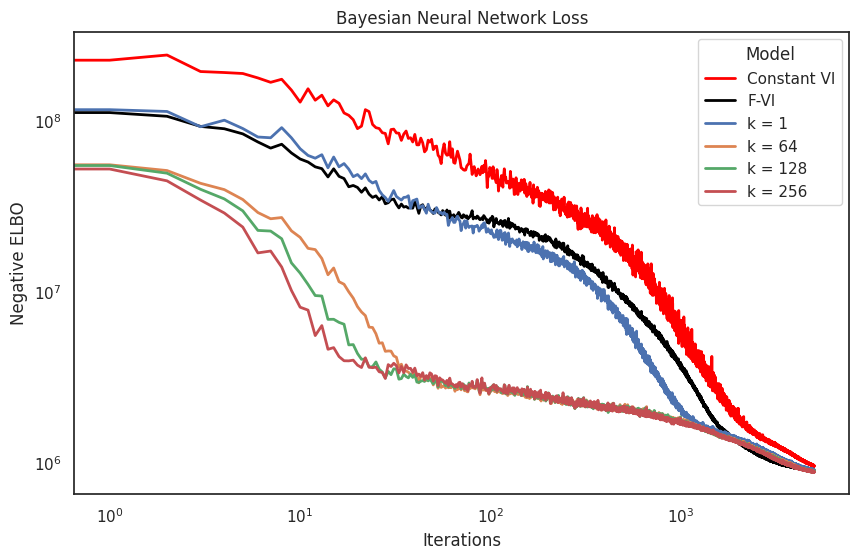

In [ ]:
n_width = len(args.nn_widths)
plotted_widths = np.array([1, 4, 16])
epochs = list(range(loss_all.shape[0]))

sns.set_theme(style="white")

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_all[:, n_width + 1], label='Constant VI', color='red', linewidth=2)
plt.plot(epochs, loss_all[:, n_width], label='F-VI', color='black', linewidth=2)

for i, width in enumerate(args.nn_widths):
    plt.plot(epochs, loss_all[:, i], label=f'k = {width}', linewidth=2)

plt.title("Bayesian Neural Network Loss")
plt.xlabel("Iterations")
plt.ylabel("Negative ELBO")
plt.yscale("log")
plt.xscale("log")

plt.legend(title="Model")

plt.savefig(f"{data_set}_elbo_BNN_{seed}.pdf")
plt.show()

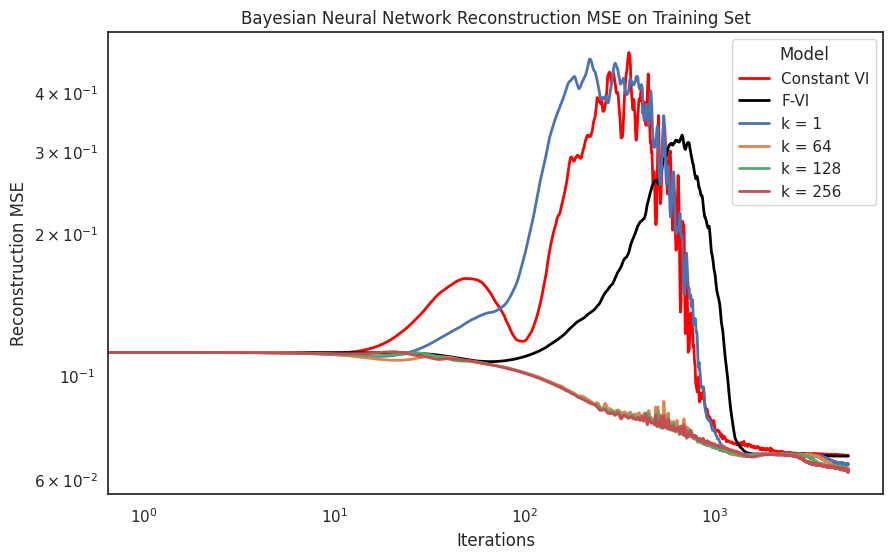

In [ ]:
n_width = len(args.nn_widths)
plotted_widths = np.array([1, 4, 16])
epochs = list(range(mse_all.shape[0]))

sns.set_theme(style="white")

plt.figure(figsize=(10, 6))
plt.plot(epochs, mse_all[:, n_width + 1], label='Constant VI', color='red', linewidth=2)
plt.plot(epochs, mse_all[:, n_width], label='F-VI', color='black', linewidth=2)

for i, width in enumerate(args.nn_widths):
    plt.plot(epochs, mse_all[:, i], label=f'k = {width}', linewidth=2)

plt.title("Bayesian Neural Network Reconstruction MSE on Training Set")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction MSE")
plt.yscale("log")
plt.xscale("log")

plt.legend(title="Model")

plt.savefig(f"{data_set}_elbo_BNN_{seed}.pdf")
plt.show()

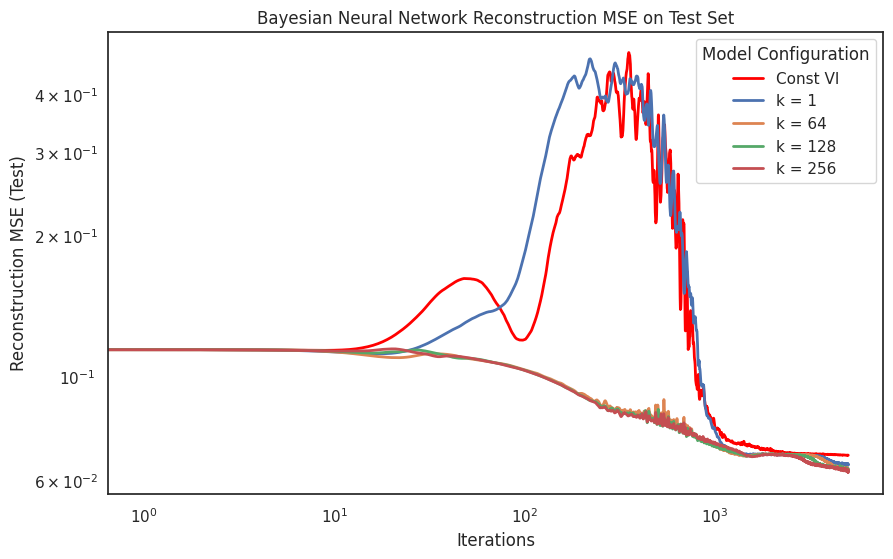

In [ ]:
n_width = len(args.nn_widths)
plotted_widths = np.array([1, 4, 16])

sns.set_theme(style="white")

plt.figure(figsize=(10, 6))

plt.plot(mse_test_all[:, n_width + 1], label='Const VI', color='red', linewidth=2)

for i, width in enumerate(args.nn_widths):
  plt.plot(mse_test_all[:, i], label=f'k = {width}', linewidth=2)

plt.title("Bayesian Neural Network Reconstruction MSE on Test Set")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction MSE (Test)")
plt.xscale("log")
plt.yscale("log")

plt.legend(title="Model Configuration")

plt.savefig(f"{data_set}_mse_test_BNN_{seed}.pdf")
plt.show()

In [ ]:
def plot_metrics_for_all_seeds(init_seed, num_seeds, args, data_set):
    sns.set_theme(style="white")

    total_plots = num_seeds * 3
    n_width = len(args.nn_widths)

    plt.figure(figsize=(20, 30))

    for seed_index in range(num_seeds):
        seed = init_seed + seed_index

        loss_all = np.load(f"results_VAE/vae_{data_set}_loss_{seed}.npy")
        mse_all = np.load(f"results_VAE/vae_{data_set}_mse_{seed}.npy")
        mse_test_all = np.load(f"results_VAE/vae_{data_set}_mse_test_{seed}.npy")

        epochs = list(range(loss_all.shape[0]))

        # Plotting Negative ELBO
        plt.subplot(num_seeds, 3, seed_index * 3 + 1)
        plt.plot(epochs, loss_all[:, n_width + 1], label='Constant VI', color='red', linewidth=2)
        plt.plot(epochs, loss_all[:, n_width], label='F-VI', color='black', linewidth=2)
        for i, width in enumerate(args.nn_widths):
            plt.plot(epochs, loss_all[:, i], label=f'k = {width}', linewidth=2)
        plt.title(f"Seed {seed}: Bayesian Neural Network Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Negative ELBO")
        plt.yscale("log")
        plt.xscale("log")
        plt.legend(title="Model")

        # Plotting Reconstruction MSE on Training Set
        plt.subplot(num_seeds, 3, seed_index * 3 + 2)
        plt.plot(epochs, mse_all[:, n_width + 1], label='Constant VI', color='red', linewidth=2)
        plt.plot(epochs, mse_all[:, n_width], label='F-VI', color='black', linewidth=2)
        for i, width in enumerate(args.nn_widths):
            plt.plot(epochs, mse_all[:, i], label=f'k = {width}', linewidth=2)
        plt.title(f"Seed {seed}: Reconstruction MSE on Training Set")
        plt.xlabel("Iterations")
        plt.ylabel("Reconstruction MSE")
        plt.yscale("log")
        plt.xscale("log")
        plt.legend(title="Model")

        # Plotting Reconstruction MSE on Test Set
        plt.subplot(num_seeds, 3, seed_index * 3 + 3)
        plt.plot(epochs, mse_test_all[:, n_width + 1], label='Const VI', color='red', linewidth=2)
        for i, width in enumerate(args.nn_widths):
            plt.plot(epochs, mse_test_all[:, i], label=f'k = {width}', linewidth=2)
        plt.title(f"Seed {seed}: Reconstruction MSE on Test Set")
        plt.xlabel("Iterations")
        plt.ylabel("Reconstruction MSE (Test)")
        plt.xscale("log")
        plt.yscale("log")
        plt.legend(title="Model Configuration")

    plt.tight_layout()
    plt.show()

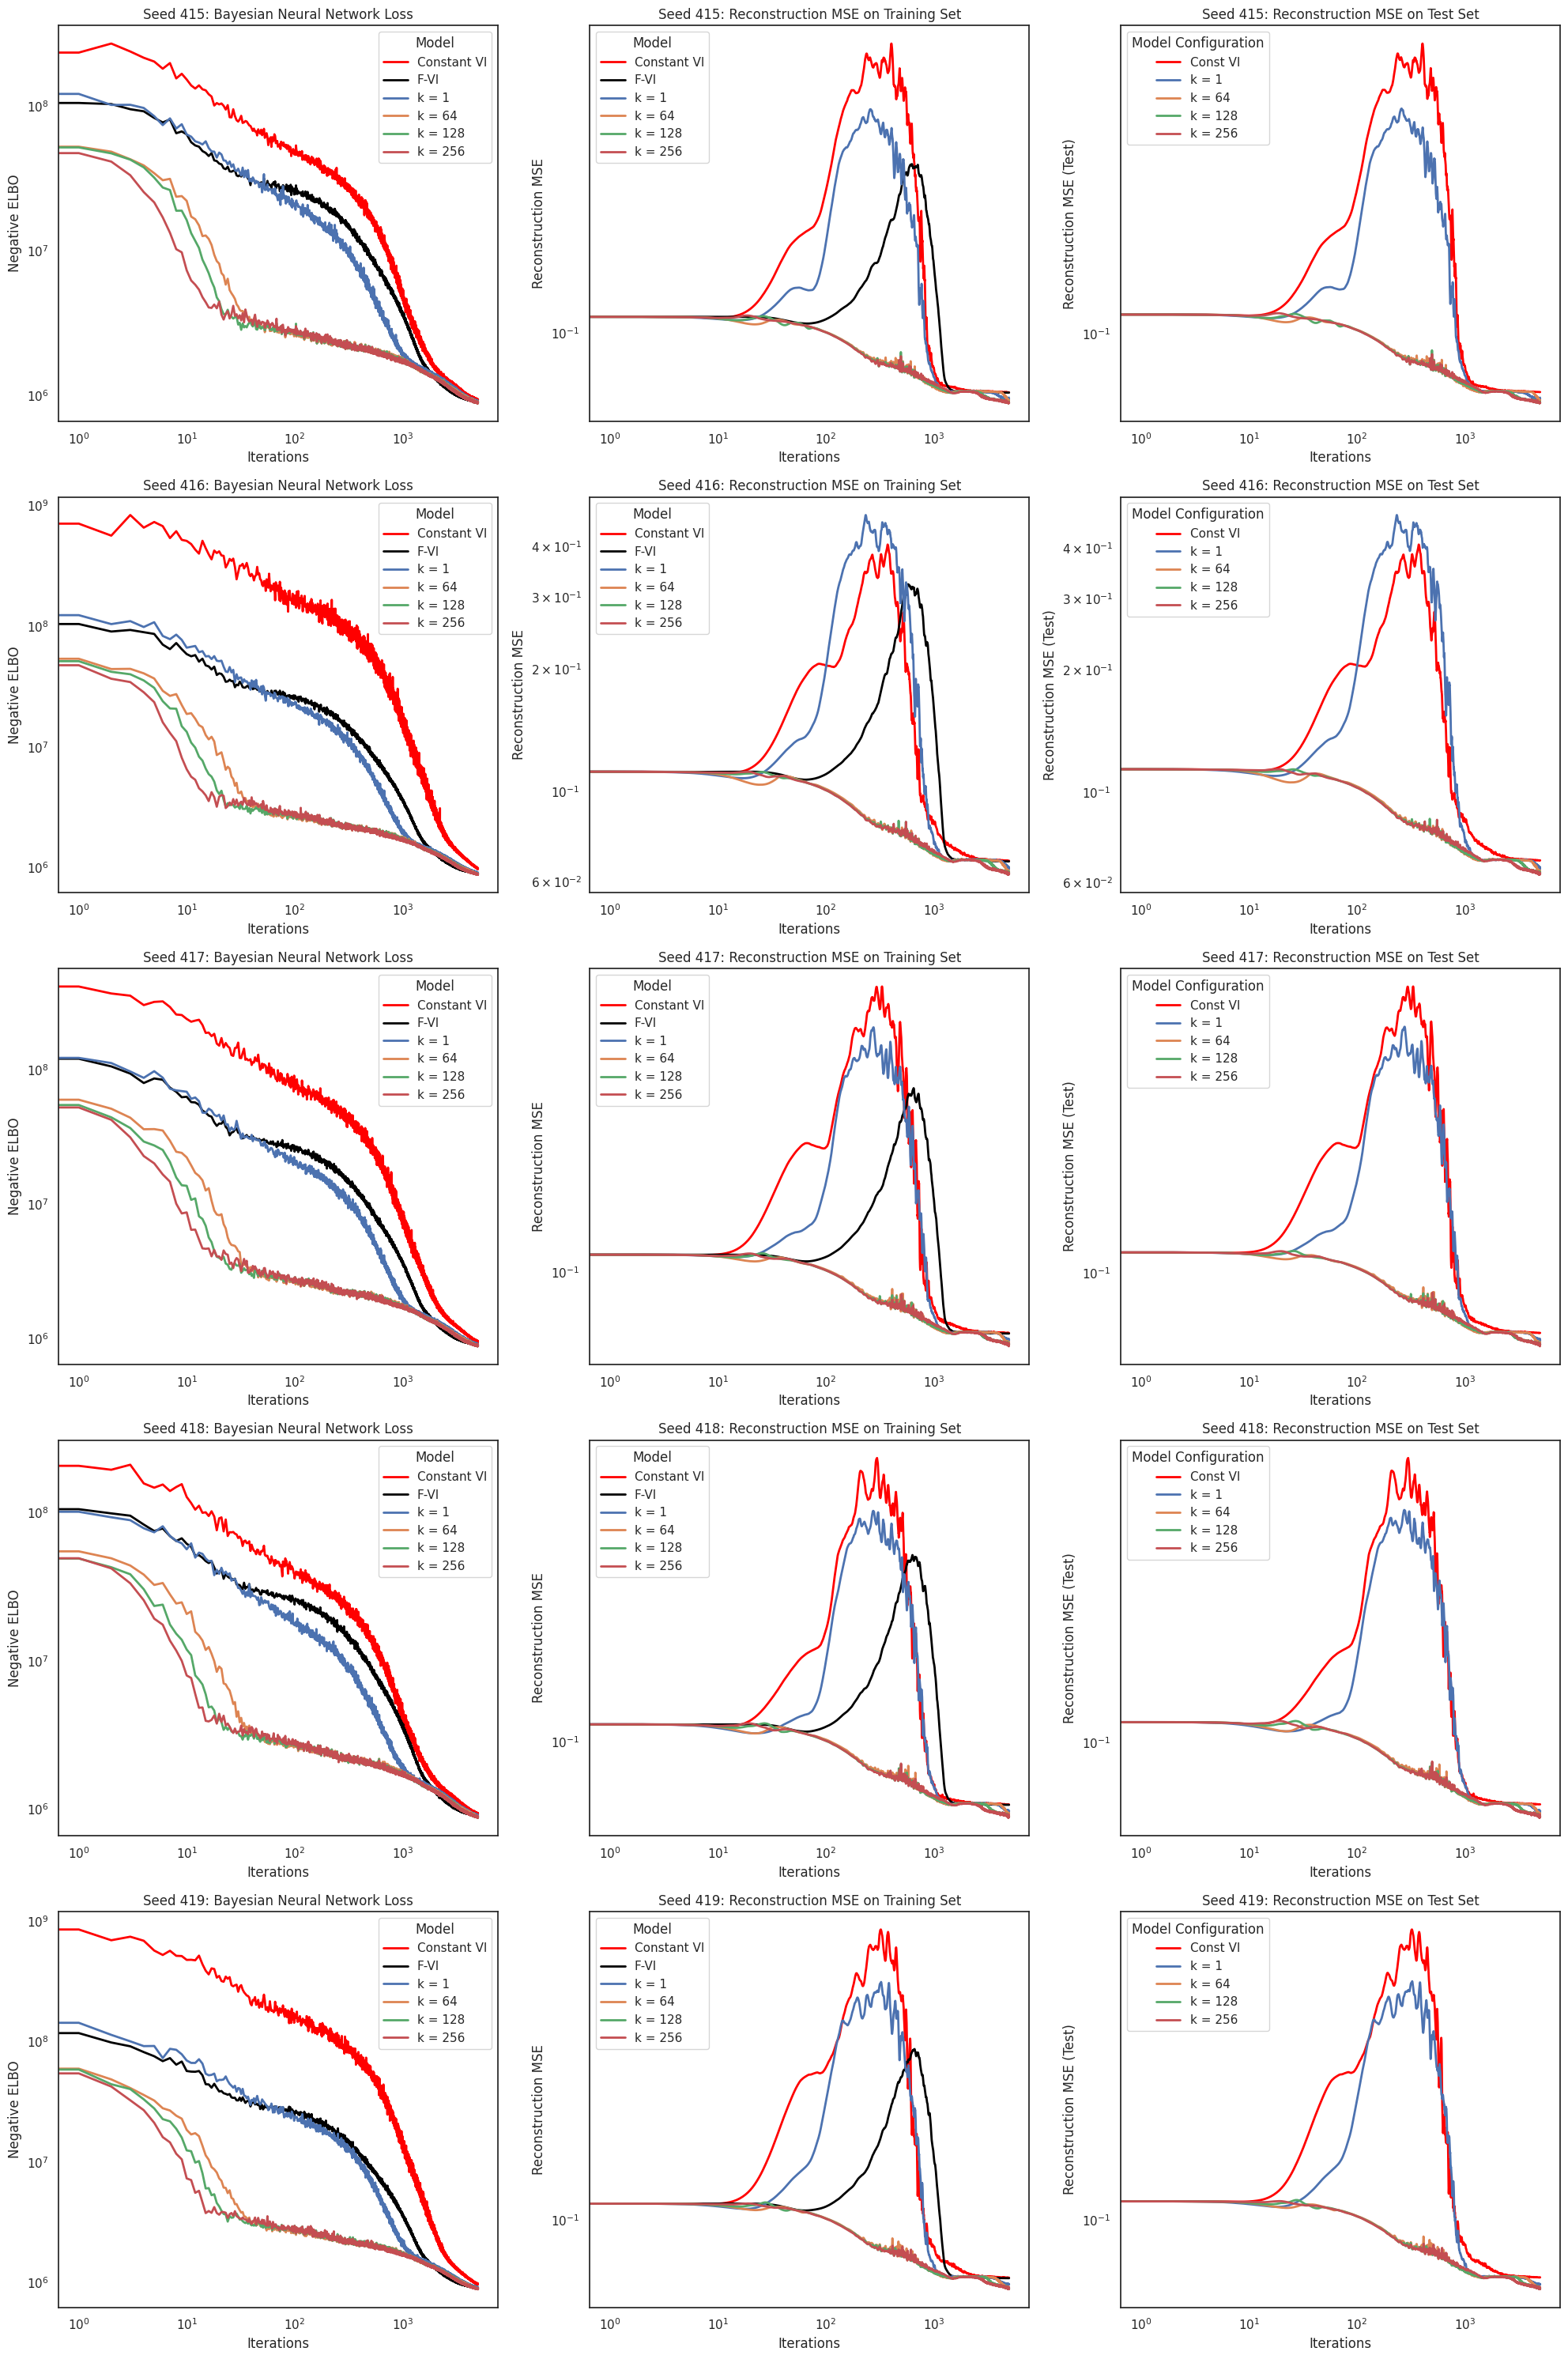

In [ ]:
plot_metrics_for_all_seeds(init_seed, 5, args, args.dataset)

### Computation Time

In [ ]:
# Plot computation time
def plot_iterations_to_tolerance(dataset, tol=0.07, init_seed=415, num_seed=5, n_algorithms=6):
    def Iter_to_tol(mse, tol, grid=1, min_epoch=0, max_epoch=5000):
        iteration = min_epoch
        error = tol + 1
        while (error > tol and iteration < (max_epoch - 1)):
            iteration += grid
            error = mse[iteration]

        return iteration

    exp_seed = [init_seed + i for i in range(num_seed)]

    iter_to_tol = np.empty((num_seed, n_algorithms))
    mse_final = np.empty((num_seed, n_algorithms))

    for i in range(num_seed):
        mse_all = np.load(f"results_VAE/vae_{data_set}_mse_{exp_seed[i]}.npy")

        for j in range(n_algorithms):
            iter_to_tol[i, j] = Iter_to_tol(mse_all[:, j], tol=tol)
            mse_final[i, j] = mse_all[-1, j]

    iter_to_tol = iter_to_tol[:, [4, 5, 0, 1, 2, 3]]
    algo_names = ["F-VI", "const"]
    algo_names += ["k=" + str(args.nn_widths[i]) for i in range(n_algorithms - 2)]

    plt.figure(figsize=(12,8))
    plt.boxplot(iter_to_tol, labels=algo_names, patch_artist=True,
                boxprops=dict(facecolor="red"), vert=False)
    plt.xscale("log")
    plt.grid(which='minor', visible='true', c='grey', alpha=0.25)
    plt.gca().invert_yaxis()

    plt.title("Bayesian Neural Network")
    plt.xlabel("Number of iterations to MSE<0.07")
    plt.show()

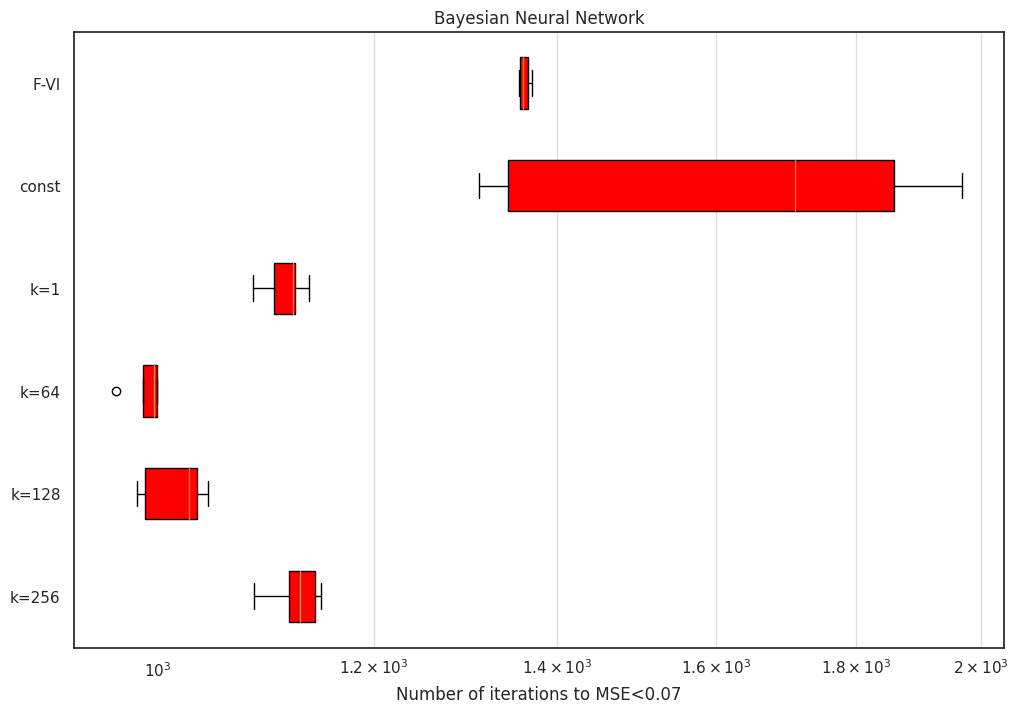

In [ ]:
plot_iterations_to_tolerance(args.dataset)

### Reconstructed Images

In [ ]:
# Show reconstructed images from the test data
experiment.display_reconstructed_images(train_loader, num_images=5, seed=args.seed)

## Conclusion

This tutorial embarked on an exploratory journey through the domain of deep Bayesian generative models, with a particular focus on closing the amortization gap in Variational Autoencoders (VAEs). Through a blend of theoretical insights and practical applications, we delved into the intricacies of amortized variational inference (A-VI), comparing it against traditional variational inference approaches such as factorized and constant variational inference.

The tutorial began with a comprehensive background on Bayesian inference, highlighting the computational challenges associated with classical methods like MCMC and the advantages offered by Variational Inference (VI). We introduced the concept of the amortization gap, which arises from the discrepancy between the true posterior distribution and its approximation via variational inference. This gap is particularly pertinent in the context of VAEs, where the inference network aims to efficiently approximate the posterior distribution for any given observation.

Our practical exploration involved setting up a Bayesian Neural Network model, implementing both the encoder and decoder components essential for a VAE. Through a series of experiments, we demonstrated how different configurations of neural network widths and variational inference techniques impact the model's performance. The results section provided a detailed analysis of the model's ability to reconstruct the input data, both on the training and test sets, and highlighted the computational efficiency achieved through amortized inference.

Key findings from our experiments include:
- Amortized variational inference significantly reduces the computational burden associated with estimating posterior distributions, making it a viable option for complex models and large datasets.
- The choice of neural network architecture and the width of layers can have a profound impact on the model's ability to approximate the true posterior distribution, thereby affecting the reconstruction accuracy.
- The experiments underscored the importance of balancing model complexity with computational efficiency, as overly complex models may not yield proportionate improvements in performance.

This tutorial has illuminated the potential of amortized variational inference in enhancing the efficiency and scalability of Bayesian generative models. By leveraging deep neural networks, we can bridge the gap between theoretical Bayesian inference and its practical application, opening new avenues for research and development in the field of machine learning and artificial intelligence. As we continue to push the boundaries of what is possible with A-VI, it is imperative to further investigate the trade-offs between approximation accuracy and computational demands, ensuring that we can harness the full power of Bayesian modeling in a wide array of applications.